In [51]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv(r"C:\Users\annab\OneDrive\Documentos\GitHub\Colabs\bases\df_mae_coruja_pre_processada.csv")

# PROCESSAMENTO

In [52]:
df_prema = df[df['mc_par_idade_gestacional_semana'] <= 36].copy()
df_normal = df[df['mc_par_idade_gestacional_semana'] > 36].copy()

df_prema['CLASSE'] = 1
df_normal['CLASSE'] = 0

In [53]:
df = df.drop(columns = ['mc_par_idade_gestacional_semana'])

In [54]:
df_balanceado_1 = df_prema[df_prema['CLASSE'] == 1].sample(n=500, random_state=42)
df_balanceado_0 = df_normal[df_normal['CLASSE'] == 0].sample(n=500, random_state=42)

df_normal = df_normal.drop(df_balanceado_0.index)
df_prema = df_prema.drop(df_balanceado_1.index)
df_teste = pd.concat([df_balanceado_1, df_balanceado_0])
df_teste.reset_index(drop=True, inplace=True)

print("DataFrame de Teste:")
print(df_teste)

DataFrame de Teste:
     mc_par_idade_gestacional_semana  mc_par_tipo_gravidez  mc_mul_est_civil  \
0                               34.0                   0.0               0.0   
1                               27.0                   0.0               5.0   
2                               33.0                   0.0               1.0   
3                               27.0                   0.0               0.0   
4                               36.0                   0.0               0.0   
..                               ...                   ...               ...   
995                             38.0                   0.0               0.0   
996                             39.0                   0.0               0.0   
997                             39.0                   0.0               5.0   
998                             38.0                   0.0               0.0   
999                             41.0                   0.0               1.0   

     mc_mul_qtd_abo

In [55]:
df_teste = df_teste.drop(columns = ['mc_par_idade_gestacional_semana'])

In [56]:
n_samples = len(df_prema)
df_normal_new = df_normal.sample(n=n_samples, random_state=42)

print("Tamanho de df_prema:", len(df_prema))
print("Tamanho de df_normal (após undersampling):", len(df_normal_new))

Tamanho de df_prema: 1435
Tamanho de df_normal (após undersampling): 1435


In [57]:
df_balanceado = pd.concat([df_prema, df_normal_new], ignore_index=True)
df_balanceado = df_balanceado.drop(columns = ['mc_par_idade_gestacional_semana'])

MODELOS


# DECISION TREE

Melhores parâmetros encontrados: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 15}
              precision    recall  f1-score   support

           0       0.55      0.71      0.62       412
           1       0.63      0.47      0.54       449

    accuracy                           0.58       861
   macro avg       0.59      0.59      0.58       861
weighted avg       0.59      0.58      0.58       861



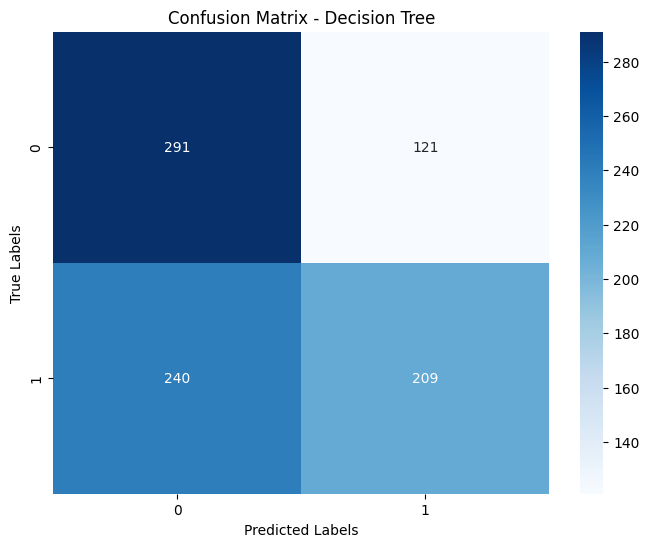

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

X = df_balanceado.drop('CLASSE', axis=1)
y = df_balanceado['CLASSE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 10]
}

dt_model = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_dt.fit(X_train, y_train)
best_params_dt = grid_search_dt.best_params_
print("Melhores parâmetros encontrados:", best_params_dt)

best_dt_model = DecisionTreeClassifier(random_state=42, **best_params_dt)
best_dt_model.fit(X_train, y_train)

y_pred_dt = best_dt_model.predict(X_test)
print(classification_report(y_test, y_pred_dt))

conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap="Blues",
            xticklabels=best_dt_model.classes_,
            yticklabels=best_dt_model.classes_,
            cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

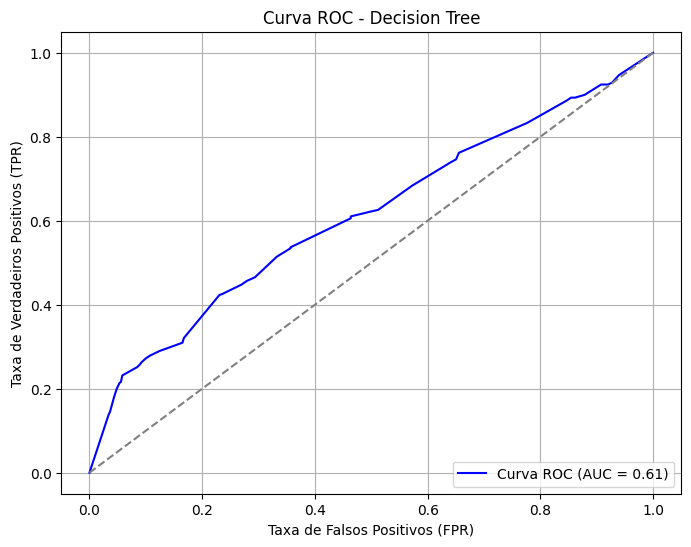

Melhor Threshold (baseado na Curva ROC): 0.5961538461538461
AUC: 0.6107315069085563


In [24]:
# ACURACIA

from sklearn.metrics import roc_curve, auc
import numpy as np

y_pred_proba_dt = best_dt_model.predict_proba(X_test)[:, 1]
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_dt)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Decision Tree')
plt.legend(loc='lower right')
plt.grid()
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = roc_thresholds[optimal_idx]

print("Melhor Threshold (baseado na Curva ROC):", optimal_threshold)
print("AUC:", roc_auc)

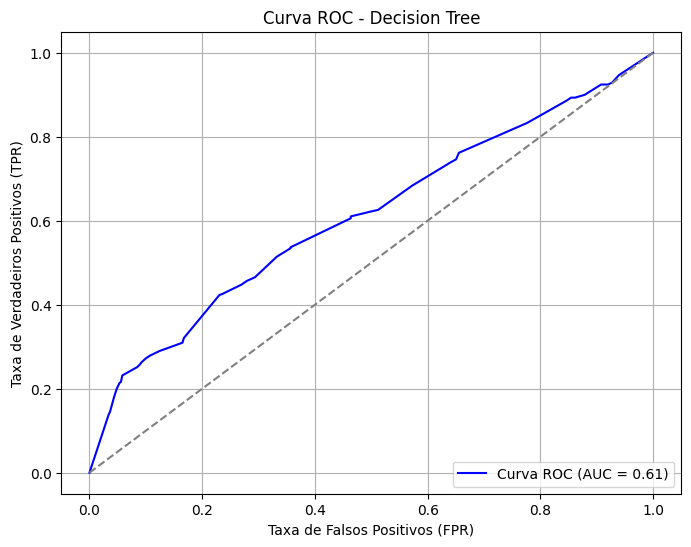

Melhor Threshold (baseado no Recall): 0.0
AUC: 0.6107315069085563


In [25]:
# SENSIBILIDADE

from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

y_pred_proba_dt = best_dt_model.predict_proba(X_test)[:, 1]

fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_dt)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Decision Tree')
plt.legend(loc='lower right')
plt.grid()
plt.show()

optimal_idx_recall = np.argmax(tpr)
optimal_threshold_recall = roc_thresholds[optimal_idx_recall]

print("Melhor Threshold (baseado no Recall):", optimal_threshold_recall)
print("AUC:", roc_auc)

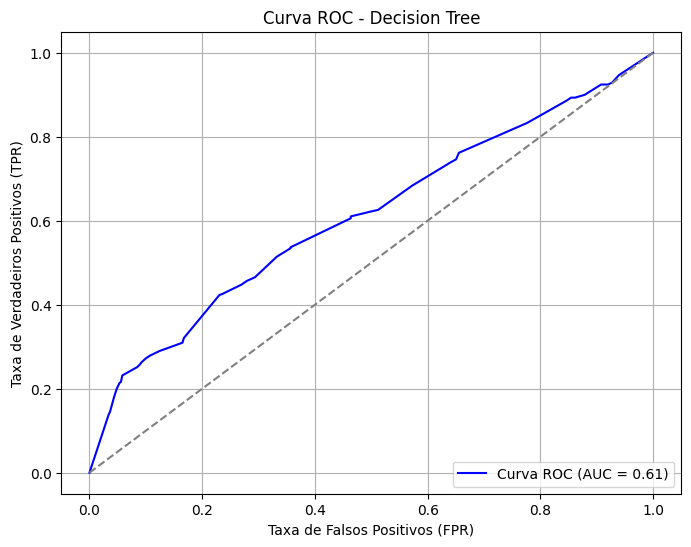

Melhor Threshold (baseado no F1-score): 0.0
AUC: 0.6107315069085563
F1-Score máximo: 0.6854961832061068


In [26]:
# F1-SCORE

from sklearn.metrics import roc_curve, auc, f1_score
import numpy as np
import matplotlib.pyplot as plt

y_pred_proba_dt = best_dt_model.predict_proba(X_test)[:, 1]

fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_dt)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Decision Tree')
plt.legend(loc='lower right')
plt.grid()
plt.show()

f1_scores = []
for threshold in roc_thresholds:
    y_pred_threshold = (y_pred_proba_dt >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    f1_scores.append(f1)

optimal_idx_f1 = np.argmax(f1_scores)
optimal_threshold_f1 = roc_thresholds[optimal_idx_f1]

print("Melhor Threshold (baseado no F1-score):", optimal_threshold_f1)
print("AUC:", roc_auc)
print("F1-Score máximo:", f1_scores[optimal_idx_f1])

In [27]:
# THRESHOLDS
print('ACURACIA',optimal_threshold)
print('SENSIBILIDADE',optimal_threshold_recall)
print('F1-SCORE',optimal_threshold_f1)

ACURACIA 0.5961538461538461
SENSIBILIDADE 0.0
F1-SCORE 0.0


c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

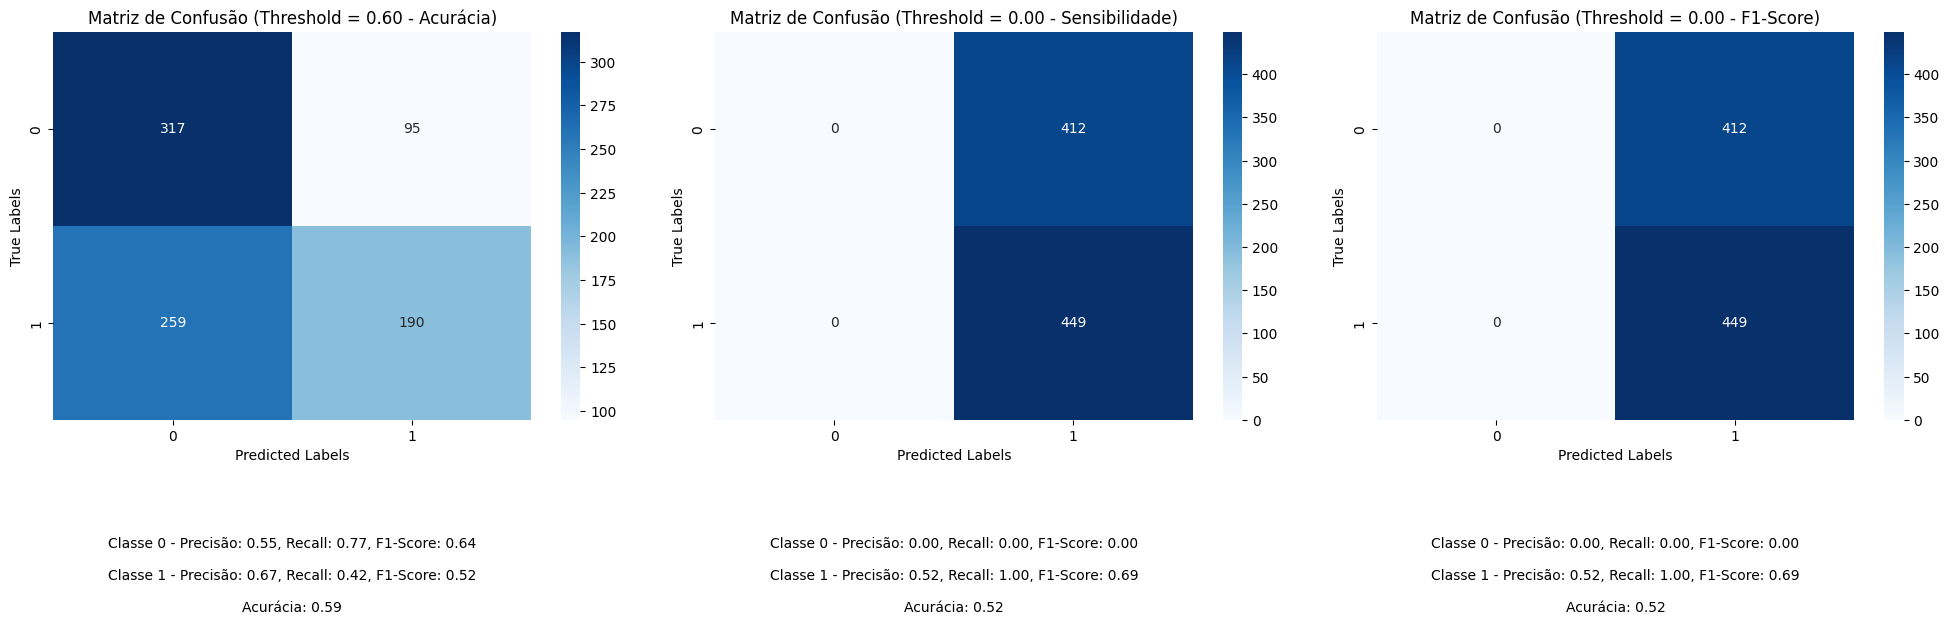

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_proba_dt = best_dt_model.predict_proba(X_test)[:, 1]

threshold_accuracy = optimal_threshold
threshold_recall = optimal_threshold_recall
threshold_f1 = optimal_threshold_f1

thresholds = [("Acurácia", threshold_accuracy),
              ("Sensibilidade", threshold_recall),
              ("F1-Score", threshold_f1)]

fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for i, (name, threshold) in enumerate(thresholds):
    y_pred_threshold_dt = (y_pred_proba_dt >= threshold).astype(int)

    conf_matrix_threshold_rf = confusion_matrix(y_test, y_pred_threshold_dt)

    sns.heatmap(conf_matrix_threshold_rf, annot=True, fmt='d', cmap="Blues",
                xticklabels=best_dt_model.classes_,
                yticklabels=best_dt_model.classes_,
                cbar=True, ax=axes[i])
    axes[i].set_xlabel('Predicted Labels')
    axes[i].set_ylabel('True Labels')
    axes[i].set_title(f'Matriz de Confusão (Threshold = {threshold:.2f} - {name})')

    class_report_dict = classification_report(y_test, y_pred_threshold_dt, output_dict=True)

    class_report_text = (
        f"Classe 0 - Precisão: {class_report_dict['0']['precision']:.2f}, "
        f"Recall: {class_report_dict['0']['recall']:.2f}, "
        f"F1-Score: {class_report_dict['0']['f1-score']:.2f}\n\n"
        f"Classe 1 - Precisão: {class_report_dict['1']['precision']:.2f}, "
        f"Recall: {class_report_dict['1']['recall']:.2f}, "
        f"F1-Score: {class_report_dict['1']['f1-score']:.2f}\n\n"
        f"Acurácia: {class_report_dict['accuracy']:.2f}"
    )

    axes[i].text(0.5, -0.3, class_report_text, ha="center", va="top",
                 fontsize=10, transform=axes[i].transAxes)

plt.tight_layout(rect=[0, 0.25, 1, 1])
plt.show()

In [29]:
y_pred_proba_dt = np.array(y_pred_proba_dt)

results = {
    "Métrica": [],
    "Acurácia": [],
    "Sensibilidade (Recall)": [],
    "Precisão": [],
    "F1-Score": []
}

for name, threshold in thresholds:
   
    y_pred_threshold_dt = (y_pred_proba_dt >= threshold).astype(int)

    report = classification_report(y_test, y_pred_threshold_dt, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred_threshold_dt)

    # Append results
    results["Métrica"].append(name)
    results["Acurácia"].append(accuracy)
    results["Sensibilidade (Recall)"].append(report['1']['recall'])
    results["Precisão"].append(report['1']['precision'])
    results["F1-Score"].append(report['1']['f1-score'])

results_df = pd.DataFrame(results)

c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
df_results

{'Métrica': ['Acurácia', 'Sensibilidade', 'F1-Score'],
 'Acurácia': [0.5888501742160279, 0.521486643437863, 0.521486643437863],
 'Sensibilidade (Recall)': [0.42316258351893093, 1.0, 1.0],
 'Precisão': [0.6666666666666666, 0.521486643437863, 0.521486643437863],
 'F1-Score': [0.5177111716621253, 0.6854961832061068, 0.6854961832061068]}

In [31]:
ppv_df = results_df[["Métrica", "Precisão"]]
ppv_df

,Métrica,Precisão
0,Acurácia,0.666667
1,Sensibilidade,0.521487
2,F1-Score,0.521487


# RANDOM FOREST

Melhores parâmetros encontrados: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.57      0.64      0.61       412
           1       0.63      0.56      0.59       449

    accuracy                           0.60       861
   macro avg       0.60      0.60      0.60       861
weighted avg       0.60      0.60      0.60       861



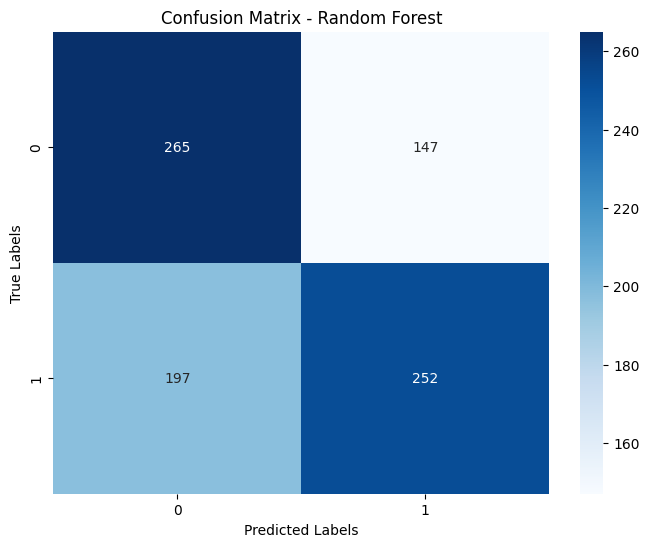

In [60]:
from sklearn.ensemble import RandomForestClassifier

X = df_balanceado.drop('CLASSE', axis=1)
y = df_balanceado['CLASSE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid_rf = {
    'n_estimators': [25, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
print("Melhores parâmetros encontrados:", best_params_rf)

best_rf_model = RandomForestClassifier(random_state=42, **best_params_rf)
best_rf_model.fit(X_train, y_train)

y_pred_rf = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap="Blues",
            xticklabels=best_rf_model.classes_,
            yticklabels=best_rf_model.classes_,
            cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest')
plt.show()

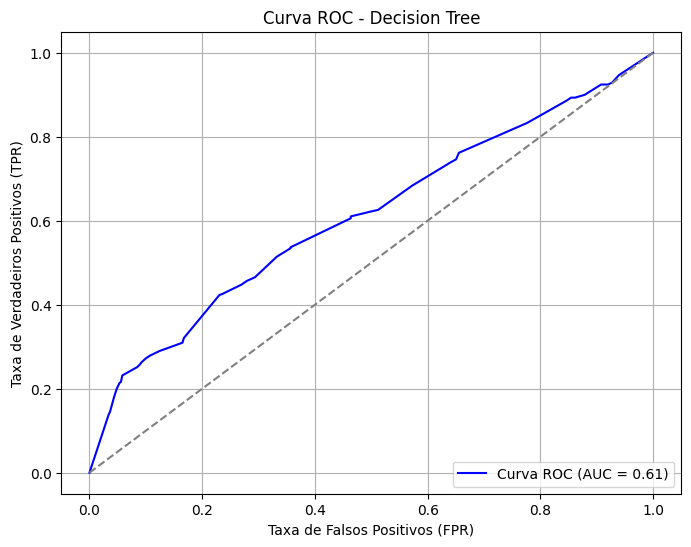

Melhor Threshold (baseado na Curva ROC): 0.5961538461538461
AUC: 0.6107315069085563


In [61]:
## ACURACIA

from sklearn.metrics import roc_curve, auc
import numpy as np

y_pred_proba_dt = best_dt_model.predict_proba(X_test)[:, 1]
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_dt)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Decision Tree')
plt.legend(loc='lower right')
plt.grid()
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = roc_thresholds[optimal_idx]

print("Melhor Threshold (baseado na Curva ROC):", optimal_threshold)
print("AUC:", roc_auc)


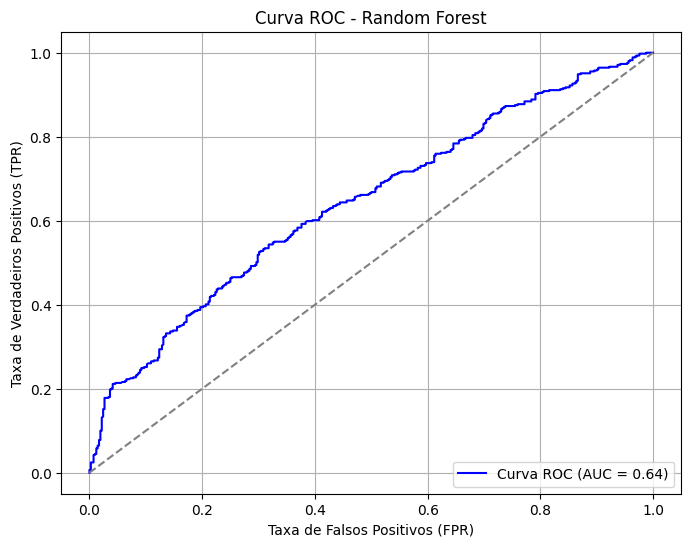

Melhor Threshold (baseado no Recall): 0.19783563005621838
AUC: 0.6428687266201051


In [62]:
# SENSIBILIDADE

from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

y_pred_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.grid()
plt.show()

optimal_idx_recall = np.argmax(tpr)
optimal_threshold_recall = roc_thresholds[optimal_idx_recall]

print("Melhor Threshold (baseado no Recall):", optimal_threshold_recall)
print("AUC:", roc_auc)

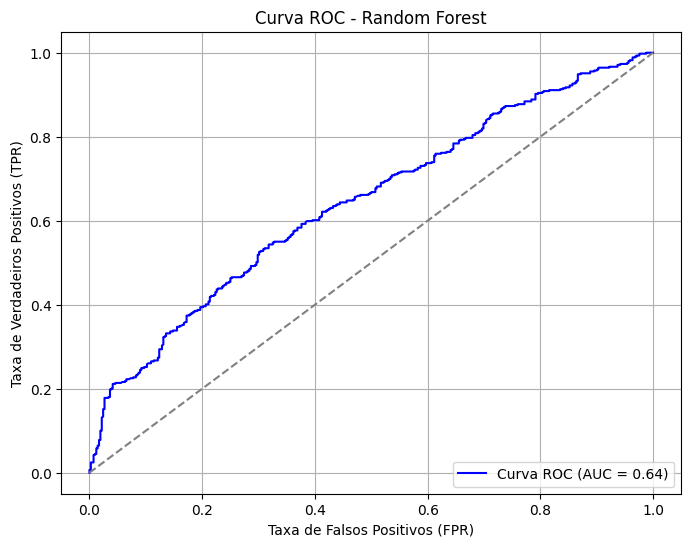

Melhor Threshold (baseado no F1-score): 0.3162564968740718
AUC: 0.6428687266201051


In [63]:
## F1-SCORE

from sklearn.metrics import roc_curve, auc, f1_score
import numpy as np
import matplotlib.pyplot as plt

y_pred_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.grid()
plt.show()

f1_scores = []
for threshold in roc_thresholds:
    y_pred_threshold = (y_pred_proba_rf >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    f1_scores.append(f1)

optimal_idx_f1 = np.argmax(f1_scores)
optimal_threshold_f1 = roc_thresholds[optimal_idx_f1]

print("Melhor Threshold (baseado no F1-score):", optimal_threshold_f1)
print("AUC:", roc_auc)

In [64]:
# THRESHOLDS
print('ACURACIA',optimal_threshold)
print('SENSIBILIDADE',optimal_threshold_recall)
print('F1-SCORE',optimal_threshold_f1)

ACURACIA 0.5961538461538461
SENSIBILIDADE 0.19783563005621838
F1-SCORE 0.3162564968740718


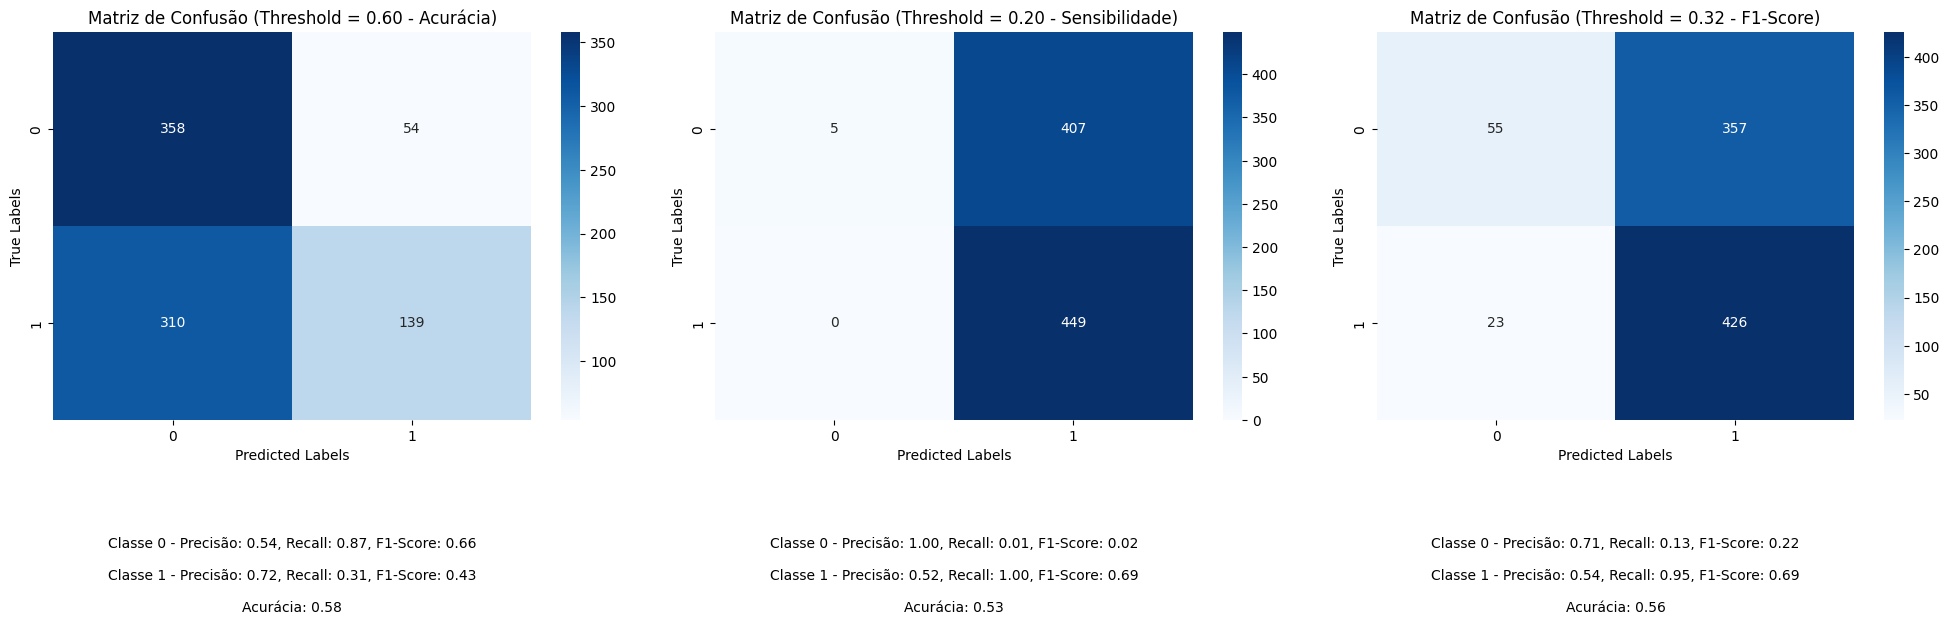

In [65]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

threshold_accuracy = optimal_threshold
threshold_recall = optimal_threshold_recall
threshold_f1 = optimal_threshold_f1

thresholds = [("Acurácia", threshold_accuracy),
              ("Sensibilidade", threshold_recall),
              ("F1-Score", threshold_f1)]

fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for i, (name, threshold) in enumerate(thresholds):
    y_pred_threshold_rf = (y_pred_proba_rf >= threshold).astype(int)

    conf_matrix_threshold_rf = confusion_matrix(y_test, y_pred_threshold_rf)

    sns.heatmap(conf_matrix_threshold_rf, annot=True, fmt='d', cmap="Blues",
                xticklabels=best_rf_model.classes_,
                yticklabels=best_rf_model.classes_,
                cbar=True, ax=axes[i])
    axes[i].set_xlabel('Predicted Labels')
    axes[i].set_ylabel('True Labels')
    axes[i].set_title(f'Matriz de Confusão (Threshold = {threshold:.2f} - {name})')

    class_report_dict = classification_report(y_test, y_pred_threshold_rf, output_dict=True)

    class_report_text = (
        f"Classe 0 - Precisão: {class_report_dict['0']['precision']:.2f}, "
        f"Recall: {class_report_dict['0']['recall']:.2f}, "
        f"F1-Score: {class_report_dict['0']['f1-score']:.2f}\n\n"
        f"Classe 1 - Precisão: {class_report_dict['1']['precision']:.2f}, "
        f"Recall: {class_report_dict['1']['recall']:.2f}, "
        f"F1-Score: {class_report_dict['1']['f1-score']:.2f}\n\n"
        f"Acurácia: {class_report_dict['accuracy']:.2f}"
    )

    axes[i].text(0.5, -0.3, class_report_text, ha="center", va="top",
                 fontsize=10, transform=axes[i].transAxes)

plt.tight_layout(rect=[0, 0.25, 1, 1])
plt.show()

In [ ]:
y_pred_proba_rf = np.array(y_pred_proba_rf)

results = {
    "Métrica": [],
    "Acurácia": [],
    "Sensibilidade (Recall)": [],
    "Precisão": [],
    "F1-Score": []
}

for name, threshold in thresholds:
   
    y_pred_threshold_dt = (y_pred_proba_rf >= threshold).astype(int)

    report = classification_report(y_test, y_pred_threshold_dt, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred_threshold_dt)

    # Append results
    results["Métrica"].append(name)
    results["Acurácia"].append(accuracy)
    results["Sensibilidade (Recall)"].append(report['1']['recall'])
    results["Precisão"].append(report['1']['precision'])
    results["F1-Score"].append(report['1']['f1-score'])

results_df = pd.DataFrame(results)

In [68]:
results_df

,Métrica,Acurácia,Sensibilidade (Recall),Precisão,F1-Score
0,Acurácia,0.588850,0.423163,0.666667,0.517711
1,Sensibilidade,0.519164,0.928731,0.521902,0.668269
2,F1-Score,0.562137,0.761693,0.558824,0.644675


# ADA BOOST

c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Melhores parâmetros encontrados: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 50}


c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.61      0.75      0.67     16247
           1       0.69      0.54      0.61     16577

    accuracy                           0.64     32824
   macro avg       0.65      0.64      0.64     32824
weighted avg       0.65      0.64      0.64     32824



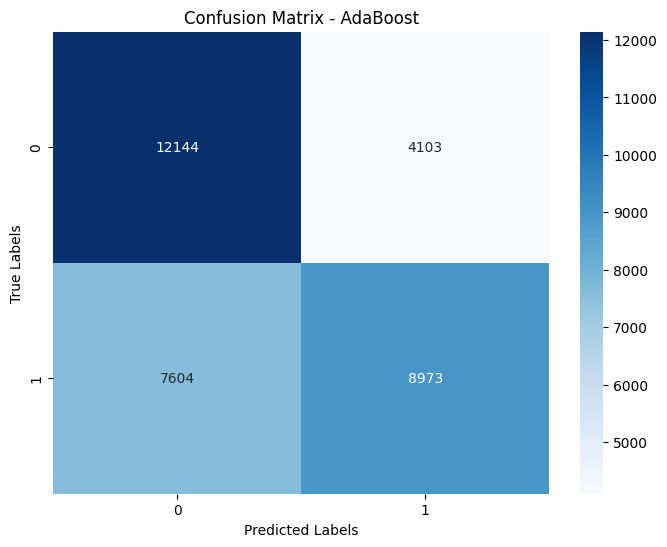

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

X = df_unificado.drop('CLASSE', axis=1)
y = df_unificado['CLASSE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid_ab = {
    'n_estimators': [25, 50, 100],
    'learning_rate': [1.0, 2.0, 3.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

ab_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), random_state=42)
grid_search_ab = GridSearchCV(estimator=ab_model, param_grid=param_grid_ab, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_ab.fit(X_train, y_train)
best_params_ab = grid_search_ab.best_params_
print("Melhores parâmetros encontrados:", best_params_ab)

best_ab_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), random_state=42, **best_params_ab)
best_ab_model.fit(X_train, y_train)

y_pred_ab = best_ab_model.predict(X_test)
print(classification_report(y_test, y_pred_ab))

conf_matrix_ab = confusion_matrix(y_test, y_pred_ab)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ab, annot=True, fmt='d', cmap="Blues",
            xticklabels=best_ab_model.classes_,
            yticklabels=best_ab_model.classes_,
            cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - AdaBoost')
plt.show()

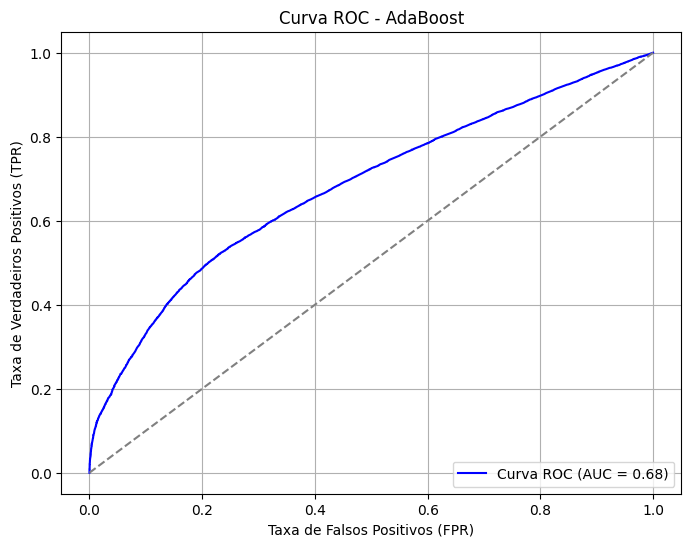

Melhor Threshold (baseado na Curva ROC): 0.5005395785536146
AUC: 0.6815732913400927


In [27]:
# ACURÁCIA

from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

y_pred_proba_ab = best_ab_model.predict_proba(X_test)[:, 1]

fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_ab)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - AdaBoost')
plt.legend(loc='lower right')
plt.grid()
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = roc_thresholds[optimal_idx]

print("Melhor Threshold (baseado na Curva ROC):", optimal_threshold)
print("AUC:", roc_auc)

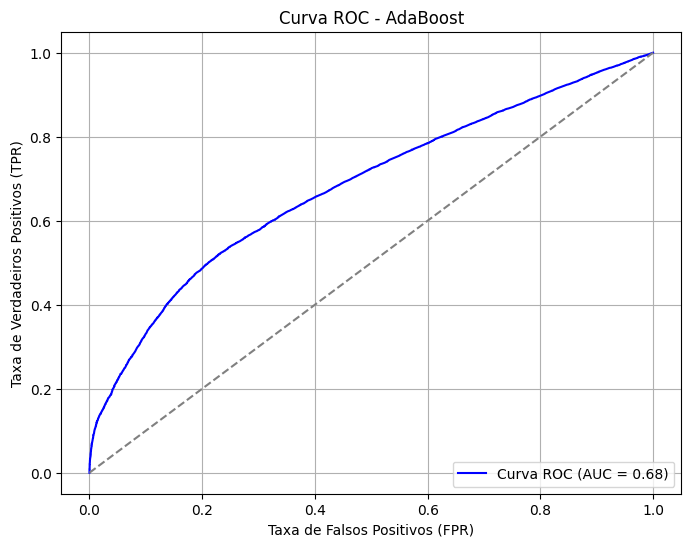

Melhor Threshold (baseado no Recall): 0.4927726831113961
AUC: 0.6815732913400927


In [28]:
# SENSIBILIDADE

from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

y_pred_proba_ab = best_ab_model.predict_proba(X_test)[:, 1]

fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_ab)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - AdaBoost')
plt.legend(loc='lower right')
plt.grid()
plt.show()

optimal_idx_recall = np.argmax(tpr)
optimal_threshold_recall = roc_thresholds[optimal_idx_recall]

print("Melhor Threshold (baseado no Recall):", optimal_threshold_recall)
print("AUC:", roc_auc)

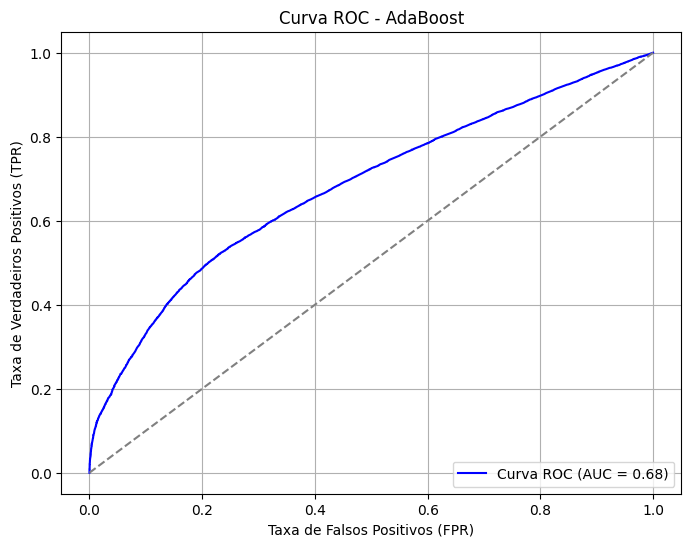

Melhor Threshold (baseado no F1-score): 0.4962747938590593
AUC: 0.6815732913400927
F1-Score máximo: 0.6724115974020461


In [29]:
# F1-SCORE

from sklearn.metrics import roc_curve, auc, f1_score
import numpy as np
import matplotlib.pyplot as plt

y_pred_proba_ab = best_ab_model.predict_proba(X_test)[:, 1]

fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_ab)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - AdaBoost')
plt.legend(loc='lower right')
plt.grid()
plt.show()

f1_scores = []
for threshold in roc_thresholds:
    y_pred_threshold = (y_pred_proba_ab >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    f1_scores.append(f1)

optimal_idx_f1 = np.argmax(f1_scores)
optimal_threshold_f1 = roc_thresholds[optimal_idx_f1]

print("Melhor Threshold (baseado no F1-score):", optimal_threshold_f1)
print("AUC:", roc_auc)
print("F1-Score máximo:", f1_scores[optimal_idx_f1])

In [30]:
# THRESHOLDS
print('ACURACIA',optimal_threshold)
print('SENSIBILIDADE',optimal_threshold_recall)
print('F1-SCORE',optimal_threshold_f1)

ACURACIA 0.5005395785536146
SENSIBILIDADE 0.4927726831113961
F1-SCORE 0.4962747938590593


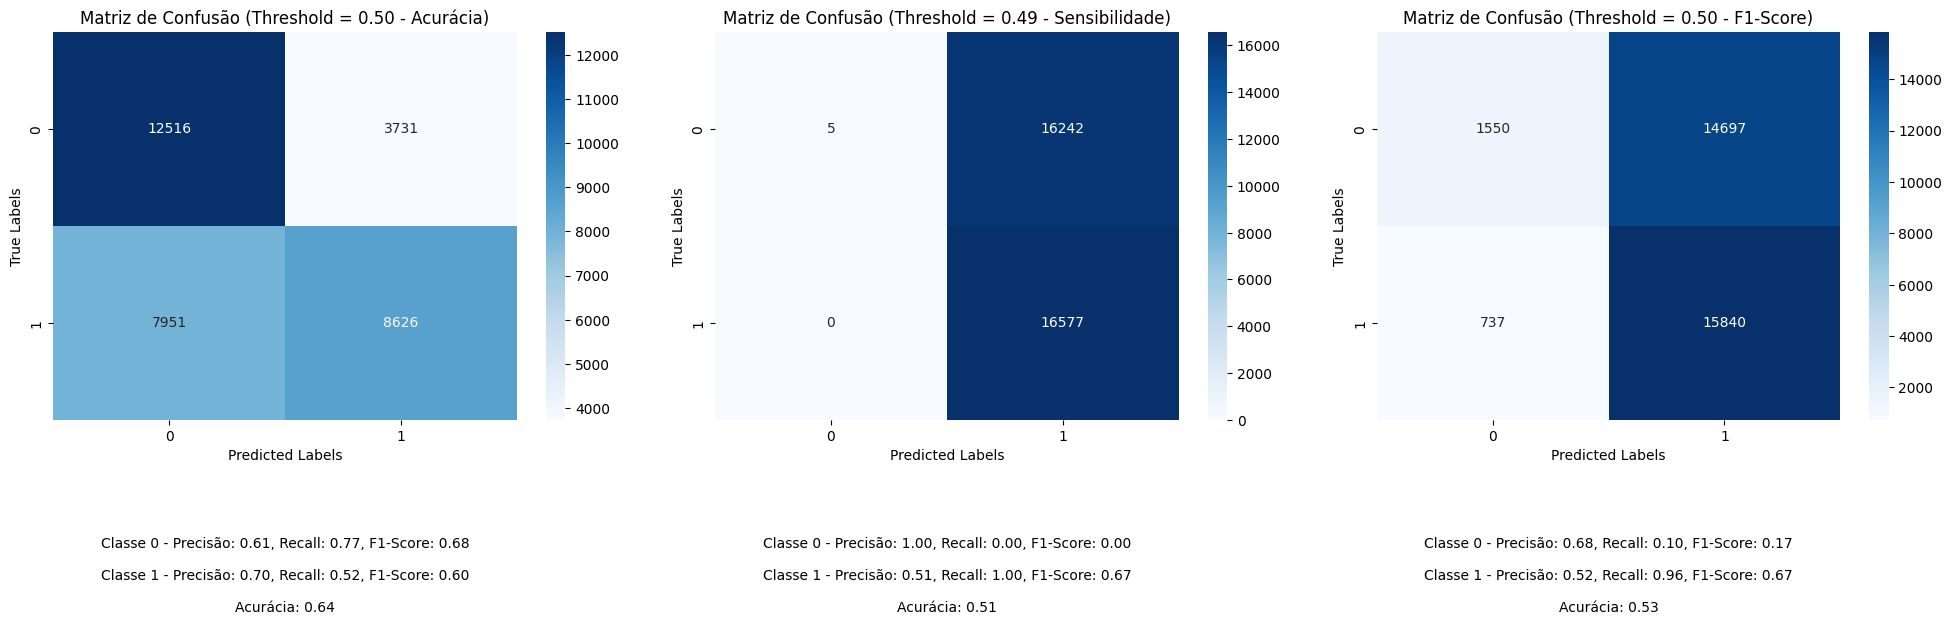

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_proba_ab = best_ab_model.predict_proba(X_test)[:, 1]

threshold_accuracy = optimal_threshold
threshold_recall = optimal_threshold_recall
threshold_f1 = optimal_threshold_f1

thresholds = [("Acurácia", threshold_accuracy),
              ("Sensibilidade", threshold_recall),
              ("F1-Score", threshold_f1)]

fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for i, (name, threshold) in enumerate(thresholds):
    y_pred_threshold_ab = (y_pred_proba_ab >= threshold).astype(int)

    conf_matrix_threshold_rf = confusion_matrix(y_test, y_pred_threshold_ab)

    sns.heatmap(conf_matrix_threshold_rf, annot=True, fmt='d', cmap="Blues",
                xticklabels=best_dt_model.classes_,
                yticklabels=best_dt_model.classes_,
                cbar=True, ax=axes[i])
    axes[i].set_xlabel('Predicted Labels')
    axes[i].set_ylabel('True Labels')
    axes[i].set_title(f'Matriz de Confusão (Threshold = {threshold:.2f} - {name})')

    class_report_dict = classification_report(y_test, y_pred_threshold_ab, output_dict=True)

    class_report_text = (
        f"Classe 0 - Precisão: {class_report_dict['0']['precision']:.2f}, "
        f"Recall: {class_report_dict['0']['recall']:.2f}, "
        f"F1-Score: {class_report_dict['0']['f1-score']:.2f}\n\n"
        f"Classe 1 - Precisão: {class_report_dict['1']['precision']:.2f}, "
        f"Recall: {class_report_dict['1']['recall']:.2f}, "
        f"F1-Score: {class_report_dict['1']['f1-score']:.2f}\n\n"
        f"Acurácia: {class_report_dict['accuracy']:.2f}"
    )

    axes[i].text(0.5, -0.3, class_report_text, ha="center", va="top",
                 fontsize=10, transform=axes[i].transAxes)

plt.tight_layout(rect=[0, 0.25, 1, 1])
plt.show()

In [ ]:
y_pred_proba_dt = np.array(y_pred_proba_dt)

results = {
    "Métrica": [],
    "Acurácia": [],
    "Sensibilidade (Recall)": [],
    "Precisão": [],
    "F1-Score": []
}

for name, threshold in thresholds:
   
    y_pred_threshold_dt = (y_pred_proba_dt >= threshold).astype(int)

    report = classification_report(y_test, y_pred_threshold_dt, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred_threshold_dt)

    # Append results
    results["Métrica"].append(name)
    results["Acurácia"].append(accuracy)
    results["Sensibilidade (Recall)"].append(report['1']['recall'])
    results["Precisão"].append(report['1']['precision'])
    results["F1-Score"].append(report['1']['f1-score'])

results_df = pd.DataFrame(results)